In [2]:
!pip install pgmpy
!apt install libgraphviz-dev
!pip install pygraphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 53.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libatk1.0-0 libatk1.0-data libgail-common libgail18 libgtk2.0-0
  libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk librsvg2-common
  libxcomposite1 libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libatk1.0-0 libatk1.0-data libgail-common libgail18 libgraphviz-dev
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxcomposite1 libxdot4
0 upgraded, 12 newly installed, 0 to remove and 41 not upgraded.
Need to get 2,496 kB of archives.
After this operation, 7,963 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libatk1.0-data all 2.36.0-3build1 [2,824 B]
Get:2 http:/

In [3]:
#import os
#os.add_dll_directory(r"C:\Program Files\Graphviz\bin")

import pygraphviz as pgv

In [170]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

# Dataset pre-analysis and pruning

In [7]:
data2 = pd.read_csv("beer_reviews.csv").drop(columns=["index"])
data2 = data2[data2["beer_abv"].notna()]
data2["review_profilename"] = data2["review_profilename"].fillna("anonymous")
data2 = data2[data2["brewery_name"].notna()]

In [8]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1518814 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1518814 non-null  int64  
 1   brewery_name        1518814 non-null  object 
 2   review_time         1518814 non-null  int64  
 3   review_overall      1518814 non-null  float64
 4   review_aroma        1518814 non-null  float64
 5   review_appearance   1518814 non-null  float64
 6   review_profilename  1518814 non-null  object 
 7   beer_style          1518814 non-null  object 
 8   review_palate       1518814 non-null  float64
 9   review_taste        1518814 non-null  float64
 10  beer_name           1518814 non-null  object 
 11  beer_abv            1518814 non-null  float64
 12  beer_beerid         1518814 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 162.2+ MB


In [9]:
# Count total entries per brewery
brewery_total_entries = (
    data2.groupby("brewery_name")
    .size()
    .reset_index(name="total_entries")
)

# Count unique beers per brewery
brewery_unique_beers = (
    data2.groupby("brewery_name")["beer_name"]
    .nunique()
    .reset_index(name="unique_beer_count")
)

# Merge both metrics
brewery_stats = pd.merge(brewery_total_entries, brewery_unique_beers, on="brewery_name")

# Sort by total entries (descending)
brewery_stats_sorted = brewery_stats.sort_values("total_entries", ascending=False)

# Show top 10 breweries with most entries and their unique beers
brewery_stats_sorted.head(10)


,brewery_name,total_entries,unique_beer_count
634,Boston Beer Company (Samuel Adams),38812,97
1793,Dogfish Head Brewery,33800,100
4457,Stone Brewing Co.,33022,119
4273,Sierra Nevada Brewing Co.,28637,121
375,"Bell's Brewery, Inc.",24975,96
4058,Rogue Ales,23450,90
2056,Founders Brewing Company,19955,130
4896,Victory Brewing Company,19407,107
2893,Lagunitas Brewing Company,16771,71
210,Avery Brewing Company,16044,93


In [9]:
data2[data2["brewery_name"]=="Boston Beer Company (Samuel Adams)"].shape

(38812, 13)

## Sub-dataset definition

In [13]:
data2 = data2[data2["brewery_name"]=="Boston Beer Company (Samuel Adams)"]

In [15]:
unique_reviewers = data2["review_profilename"].unique().tolist()
unique_beers = data2["beer_name"].unique().tolist()
unique_styles = data2["beer_style"].unique().tolist()

print(f"Number of unique reviewers: {len(unique_reviewers)}")
print(f"Number of unique beers: {len(unique_beers)}")
print(f"Number of unique styles: {len(unique_styles)}")

Number of unique reviewers: 7251
Number of unique beers: 97
Number of unique styles: 50


In [188]:
review_counts = (
    data2.groupby("beer_style")
         .size()
         .reset_index(name="review_count")
         .sort_values(by="review_count", ascending=False)
)

review_counts.head(10)

,beer_style,review_count
16,Bock,3371
8,American Pale Wheat Ale,2805
49,Witbier,2566
46,Vienna Lager,2418
26,Fruit / Vegetable Beer,2259
35,Märzen / Oktoberfest,1893
6,American IPA,1631
42,Schwarzbier,1494
17,Czech Pilsener,1336
33,Milk / Sweet Stout,1239


In [83]:
top_10_styles_list = review_counts["beer_style"].head(10).tolist()

#Top 10 beer styles with most reviews 
top_10_styles = data2[data2["beer_style"].isin(top_10_styles_list)]
print(top_10_styles.shape)

(21012, 13)


## Creating a Graph with the reviews of beers from the Samuel Adams Brewery, with nodes linkedby similar reviews to beers of the same beer style

In [21]:
S2 = nx.Graph()

In [23]:
for d in top_10_styles.itertuples(index = False):
    S2.add_node(d,
                     profile_name = d.review_profilename,
                     beer_style = d.beer_style,
                     beer_name = d.beer_name,
                     beer_abv = d.beer_abv,
                     review_overall = d.review_overall,
                     review_taste = d.review_taste,
                     review_aroma = d.review_aroma,
                     review_appearance = d.review_appearance,
                     review_palate = d.review_palate
                    )


In [25]:
S3 = S2.copy()

In [87]:
# Group node indices by beer_name + review attributes
groups = defaultdict(list)

for node_id, attrs in S2.nodes(data=True):
    beer = attrs.get("beer_style")
    overall = attrs.get("review_overall")
    taste = attrs.get("review_taste")
    aroma = attrs.get("review_aroma")
    appearance = attrs.get("review_appearance")
    palate = attrs.get("review_palate")

    if beer is not None:
        key = (beer, overall, taste, aroma, appearance, palate)
        groups[key].append(node_id)

# Create edges between all nodes with the same beer_name AND identical review attributes
for key, nodes in groups.items():
    beer, overall, taste, aroma, appearance, palate = key
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            S2.add_edge(
                nodes[i],
                nodes[j],
                beer_style=beer,
                review_overall=overall,
                review_taste=taste,
                review_aroma=aroma,
                review_appearance=appearance,
                review_palate=palate
            )


In [29]:
S2.number_of_nodes()

21012

In [214]:
for id, attrs in S2.nodes(data = True):
    print (attrs)
    break

{'profile_name': 'Pahn', 'beer_style': 'Czech Pilsener', 'beer_name': 'Samuel Adams Noble Pils', 'beer_abv': 4.9, 'review_overall': 4.0, 'review_taste': 4.0, 'review_aroma': 3.0, 'review_appearance': 4.5, 'review_palate': 4.5}


In [31]:
S2.number_of_edges()

130636

In [35]:
#nx.write_gexf(S2, "Similarities_graph.gexf")

## Creating a Graph with the same nodes as the fist one, but with nodes linked if they are from the same reviewer

In [89]:
groups = defaultdict(list)

for node_id, attrs in S3.nodes(data=True):
    reviewer = attrs.get("profile_name")
    if reviewer:
        groups[reviewer].append(node_id)

for reviewer, nodes in groups.items():
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            S3.add_edge(nodes[i], nodes[j], profile_name=reviewer)

In [35]:
S3.number_of_nodes()

21012

In [37]:
S3.number_of_edges()

74250

In [43]:
#nx.write_gexf(S3, "Reviewers_graph.gexf")

In [39]:
largest_component = max(nx.connected_components(S2), key=len)
S2_largest_component = S2.subgraph(largest_component)

print(f"Number of nodes in the largest connected component: {S2_largest_component.number_of_nodes()}")
print(f"Number of edges in the largest connected component: {S2_largest_component.number_of_edges()}")

Number of nodes in the largest connected component: 137
Number of edges in the largest connected component: 9316


In [43]:
if S2_largest_component.number_of_nodes() > 0:
    # Get the first node from the largest connected component
    first_node = next(iter(S2_largest_component.nodes(data=True)))
    node_data = first_node[1] # [1] contains the attributes dictionary

    print("Review characteristics for the largest connected component in S2:")
    print(f"  Beer Style: {node_data.get('beer_style')}")
    print(f"  Overall Review: {node_data.get('review_overall')}")
    print(f"  Taste Review: {node_data.get('review_taste')}")
    print(f"  Aroma Review: {node_data.get('review_aroma')}")
    print(f"  Appearance Review: {node_data.get('review_appearance')}")
    print(f"  Palate Review: {node_data.get('review_palate')}")
else:
    print("The largest connected component in S2 is empty.")

Review characteristics for the largest connected component in S2:
  Beer Style: Bock
  Overall Review: 4.0
  Taste Review: 4.0
  Aroma Review: 4.0
  Appearance Review: 4.0
  Palate Review: 4.0


In [45]:
largest_component = max(nx.connected_components(S3), key=len)
S3_largest_component = S3.subgraph(largest_component)

print(f"Number of nodes in the largest connected component: {S3_largest_component.number_of_nodes()}")
print(f"Number of edges in the largest connected component: {S3_largest_component.number_of_edges()}")

Number of nodes in the largest connected component: 26
Number of edges in the largest connected component: 325


In [47]:
if S3_largest_component.number_of_nodes() > 0:
    # Get the first node from the largest connected component
    first_node = next(iter(S3_largest_component.nodes(data=True)))
    node_data = first_node[1] # [1] contains the attributes dictionary

    print("Review characteristics for the largest connected component in S3:")
    print(f"  Beer Style: {node_data.get('beer_style')}")
    print(f"  Overall Review: {node_data.get('review_overall')}")
    print(f"  Taste Review: {node_data.get('review_taste')}")
    print(f"  Aroma Review: {node_data.get('review_aroma')}")
    print(f"  Appearance Review: {node_data.get('review_appearance')}")
    print(f"  Palate Review: {node_data.get('review_palate')}")
else:
    print("The largest connected component in S3 is empty.")

Review characteristics for the largest connected component in S3:
  Beer Style: American IPA
  Overall Review: 3.5
  Taste Review: 4.0
  Aroma Review: 3.5
  Appearance Review: 3.5
  Palate Review: 3.5


## Subgraphs for each of  the different beer styles used, connected by same reviewer

In [49]:
top_10_styles["beer_name"].nunique()

32

In [51]:
top_10_styles.columns

Index(['brewery_id', 'brewery_name', 'review_time', 'review_overall',
       'review_aroma', 'review_appearance', 'review_profilename', 'beer_style',
       'review_palate', 'review_taste', 'beer_name', 'beer_abv',
       'beer_beerid'],
      dtype='object')

### Bock

In [53]:
Bock_graph = nx.Graph()
for d in top_10_styles[top_10_styles["beer_style"] == "Bock"].itertuples(index = False):
    Bock_graph.add_node(d,
                        profile_name = d.review_profilename,
                        beer_name = d.beer_name,
                        beer_abv = d.beer_abv,
                        review_overall = d.review_overall,
                        review_taste = d.review_taste,
                        review_aroma = d.review_aroma,
                        review_appearance = d.review_appearance,
                        review_palate = d.review_palate
                       )


In [55]:
Bock_graph.number_of_nodes()

3371

In [57]:
groups = defaultdict(list)

for node_id, attrs in Bock_graph.nodes(data=True):
    reviewer = attrs.get("profile_name")
    if reviewer:
        groups[reviewer].append(node_id)

for reviewer, nodes in groups.items():
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            Bock_graph.add_edge(nodes[i], nodes[j], profile_name=reviewer)


In [59]:
Bock_graph.number_of_edges()

1286

In [83]:
#nx.write_gexf(Bock_graph, "Bock_reviewers.gexf")

### "American Pale Wheat Ale

In [61]:
APWA_graph = nx.Graph()
for d in top_10_styles[top_10_styles["beer_style"] == "American Pale Wheat Ale"].itertuples(index = False):
    APWA_graph.add_node(d,
                        profile_name = d.review_profilename,
                        beer_name = d.beer_name,
                        beer_abv = d.beer_abv,
                        review_overall = d.review_overall,
                        review_taste = d.review_taste,
                        review_aroma = d.review_aroma,
                        review_appearance = d.review_appearance,
                        review_palate = d.review_palate
                       )

In [63]:
APWA_graph.number_of_nodes()

2805

In [79]:
groups = defaultdict(list)

for node_id, attrs in APWA_graph.nodes(data=True):
    reviewer = attrs.get("profile_name")
    if reviewer:
        groups[reviewer].append(node_id)

for reviewer, nodes in groups.items():
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            APWA_graph.add_edge(nodes[i], nodes[j], profile_name=reviewer)

In [67]:
APWA_graph.number_of_edges()

1133

In [95]:
#nx.write_gexf(APWA_graph, "APWA_reviewers.gexf")

### Witbier

In [69]:
Witbier_graph = nx.Graph()

In [71]:
for d in top_10_styles[top_10_styles["beer_style"] == "Witbier"].itertuples(index = False):
    Witbier_graph.add_node(d,
                        profile_name = d.review_profilename,
                        beer_name = d.beer_name,
                        beer_abv = d.beer_abv,
                        review_overall = d.review_overall,
                        review_taste = d.review_taste,
                        review_aroma = d.review_aroma,
                        review_appearance = d.review_appearance,
                        review_palate = d.review_palate
                       )

In [73]:
Witbier_graph.number_of_nodes()

2566

In [77]:
groups = defaultdict(list)

for node_id, attrs in Witbier_graph.nodes(data=True):
    reviewer = attrs.get("profile_name")
    if reviewer:
        groups[reviewer].append(node_id)

for reviewer, nodes in groups.items():
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            Witbier_graph.add_edge(nodes[i], nodes[j], profile_name=reviewer)

In [93]:
Witbier_graph.number_of_edges()

1188

In [107]:
#nx.write_gexf(Witbier_graph, "Witbier_reviewers.gexf")

### Vienna Lager

In [95]:
Vienna_graph = nx.Graph()
for d in top_10_styles[top_10_styles["beer_style"] == "Vienna Lager"].itertuples(index = False):
   Vienna_graph.add_node(d,
                        profile_name = d.review_profilename,
                        beer_name = d.beer_name,
                        beer_abv = d.beer_abv,
                        review_overall = d.review_overall,
                        review_taste = d.review_taste,
                        review_aroma = d.review_aroma,
                        review_appearance = d.review_appearance,
                        review_palate = d.review_palate
                       )

In [97]:
Vienna_graph.number_of_nodes()

2418

In [99]:
groups = defaultdict(list)

for node_id, attrs in Vienna_graph.nodes(data=True):
    reviewer = attrs.get("profile_name")
    if reviewer:
        groups[reviewer].append(node_id)

for reviewer, nodes in groups.items():
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            Vienna_graph.add_edge(nodes[i], nodes[j], profile_name=reviewer)

In [101]:
Vienna_graph.number_of_edges()

70

In [117]:
#nx.write_gexf(Vienna_graph, "Vienna_reviewers.gexf")

### Fruit / Vegetable Beer

In [103]:
Fruit_graph = nx.Graph()
for d in top_10_styles[top_10_styles["beer_style"] == "Fruit / Vegetable Beer"].itertuples(index = False):
   Fruit_graph.add_node(d,
                        profile_name = d.review_profilename,
                        beer_name = d.beer_name,
                        beer_abv = d.beer_abv,
                        review_overall = d.review_overall,
                        review_taste = d.review_taste,
                        review_aroma = d.review_aroma,
                        review_appearance = d.review_appearance,
                        review_palate = d.review_palate
                       )

In [105]:
Fruit_graph.number_of_nodes()

2259

In [107]:
groups = defaultdict(list)

for node_id, attrs in Fruit_graph.nodes(data=True):
    reviewer = attrs.get("profile_name")
    if reviewer:
        groups[reviewer].append(node_id)

# 2. Create edges between all nodes with the same reviewer
for reviewer, nodes in groups.items():
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            Fruit_graph.add_edge(nodes[i], nodes[j], profile_name=reviewer)

In [109]:
Fruit_graph.number_of_edges()

620

In [127]:
#nx.write_gexf(Fruit_graph, "Fruit_reviewers.gexf")

### Märzen / Oktoberfest

In [111]:
Marzen_graph = nx.Graph()
for d in top_10_styles[top_10_styles["beer_style"] == "Märzen / Oktoberfest"].itertuples(index = False):
   Marzen_graph.add_node(d,
                        profile_name = d.review_profilename,
                        beer_name = d.beer_name,
                        beer_abv = d.beer_abv,
                        review_overall = d.review_overall,
                        review_taste = d.review_taste,
                        review_aroma = d.review_aroma,
                        review_appearance = d.review_appearance,
                        review_palate = d.review_palate
                       )

In [114]:
Marzen_graph.number_of_nodes()

1893

In [116]:
groups = defaultdict(list)

for node_id, attrs in Marzen_graph.nodes(data=True):
    reviewer = attrs.get("profile_name")
    if reviewer:
        groups[reviewer].append(node_id)

# 2. Create edges between all nodes with the same reviewer
for reviewer, nodes in groups.items():
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            Marzen_graph.add_edge(nodes[i], nodes[j], profile_name=reviewer)

In [118]:
Marzen_graph.number_of_edges()

35

In [139]:
#nx.write_gexf(Marzen_graph, "Marzen_reviewers.gexf")

### American IPA

In [120]:
AIPA_graph = nx.Graph()
for d in top_10_styles[top_10_styles["beer_style"] == "American IPA"].itertuples(index = False):
   AIPA_graph.add_node(d,
                        profile_name = d.review_profilename,
                        beer_name = d.beer_name,
                        beer_abv = d.beer_abv,
                        review_overall = d.review_overall,
                        review_taste = d.review_taste,
                        review_aroma = d.review_aroma,
                        review_appearance = d.review_appearance,
                        review_palate = d.review_palate
                       )

In [122]:
AIPA_graph.number_of_nodes()

1631

In [124]:
groups = defaultdict(list)

for node_id, attrs in AIPA_graph.nodes(data=True):
    reviewer = attrs.get("profile_name")
    if reviewer:
        groups[reviewer].append(node_id)

# 2. Create edges between all nodes with the same reviewer
for reviewer, nodes in groups.items():
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            AIPA_graph.add_edge(nodes[i], nodes[j], profile_name=reviewer)

In [126]:
AIPA_graph.number_of_edges()

2102

In [149]:
#nx.write_gexf(AIPA_graph, "AIPA_reviewers.gexf")

### Schwarzbier

In [128]:
Schwarzbier_graph = nx.Graph()
for d in top_10_styles[top_10_styles["beer_style"] == "Schwarzbier"].itertuples(index = False):
   Schwarzbier_graph.add_node(d,
                        profile_name = d.review_profilename,
                        beer_name = d.beer_name,
                        beer_abv = d.beer_abv,
                        review_overall = d.review_overall,
                        review_taste = d.review_taste,
                        review_aroma = d.review_aroma,
                        review_appearance = d.review_appearance,
                        review_palate = d.review_palate
                       )

In [130]:
Schwarzbier_graph.number_of_nodes()

1494

In [132]:
groups = defaultdict(list)

for node_id, attrs in Schwarzbier_graph.nodes(data=True):
    reviewer = attrs.get("profile_name")
    if reviewer:
        groups[reviewer].append(node_id)

# 2. Create edges between all nodes with the same reviewer
for reviewer, nodes in groups.items():
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            Schwarzbier_graph.add_edge(nodes[i], nodes[j], profile_name=reviewer)

In [134]:
Schwarzbier_graph.number_of_edges()

1

In [159]:
#nx.write_gexf(Schwarzbier_graph, "Schwarzbier_reviewers.gexf")

### Czech Pilsener

In [136]:
Czech_graph = nx.Graph()
for d in top_10_styles[top_10_styles["beer_style"] == "Czech Pilsener"].itertuples(index = False):
   Czech_graph.add_node(d,
                        profile_name = d.review_profilename,
                        beer_name = d.beer_name,
                        beer_abv = d.beer_abv,
                        review_overall = d.review_overall,
                        review_taste = d.review_taste,
                        review_aroma = d.review_aroma,
                        review_appearance = d.review_appearance,
                        review_palate = d.review_palate
                       )

In [138]:
Czech_graph.number_of_nodes()

1336

In [140]:
groups = defaultdict(list)

for node_id, attrs in Czech_graph.nodes(data=True):
    reviewer = attrs.get("profile_name")
    if reviewer:
        groups[reviewer].append(node_id)

# 2. Create edges between all nodes with the same reviewer
for reviewer, nodes in groups.items():
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            Czech_graph.add_edge(nodes[i], nodes[j], profile_name=reviewer)

In [142]:
Czech_graph.number_of_edges()

23

In [171]:
#nx.write_gexf(Czech_graph, "Czech_reviewers.gexf")

### Milk / Sweet Stout

In [144]:
Milk_graph=nx.Graph()
for d in top_10_styles[top_10_styles["beer_style"] == "Milk / Sweet Stout"].itertuples(index = False):
   Milk_graph.add_node(d,
                        profile_name = d.review_profilename,
                        beer_name = d.beer_name,
                        beer_abv = d.beer_abv,
                        review_overall = d.review_overall,
                        review_taste = d.review_taste,
                        review_aroma = d.review_aroma,
                        review_appearance = d.review_appearance,
                        review_palate = d.review_palate
                       )

In [146]:
Milk_graph.number_of_nodes()

1239

In [148]:
groups = defaultdict(list)

for node_id, attrs in Milk_graph.nodes(data=True):
    reviewer = attrs.get("profile_name")
    if reviewer:
        groups[reviewer].append(node_id)

# 2. Create edges between all nodes with the same reviewer
for reviewer, nodes in groups.items():
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            Milk_graph.add_edge(nodes[i], nodes[j], profile_name=reviewer)

In [150]:
Milk_graph.number_of_edges()

0

In [181]:
#nx.write_gexf(Milk_graph, "Milk_reviewers.gexf")

## Identify All Connected Components



In [152]:
connected_components = list(nx.connected_components(S2))

print(f"Number of connected components in S2: {len(connected_components)}")

Number of connected components in S2: 7641


In [154]:
sorted_connected_components = sorted(connected_components, key=len, reverse=True)

print(f"Size of the largest connected component: {len(sorted_connected_components[0])}")

Size of the largest connected component: 137


In [156]:
top_10_largest_components = sorted_connected_components[:500]

largest_components_overall_reviews = []
for component in top_10_largest_components:
    for node_id in component:
        node_attrs = S2.nodes[node_id]
        largest_components_overall_reviews.append(node_attrs.get('review_overall'))

print(f"Number of review_overall values from top 10 largest components: {len(largest_components_overall_reviews)}")

Number of review_overall values from top 10 largest components: 8547


In [158]:
isolated_components = [comp for comp in sorted_connected_components if len(comp) == 1]
top_10_isolated_components = isolated_components[:500]

isolated_components_overall_reviews = []
for component in top_10_isolated_components:
    for node_id in component:
        node_attrs = S2.nodes[node_id]
        isolated_components_overall_reviews.append(node_attrs.get('review_overall'))

print(f"Number of review_overall values from top 10 isolated components: {len(isolated_components_overall_reviews)}")

Number of review_overall values from top 10 isolated components: 500


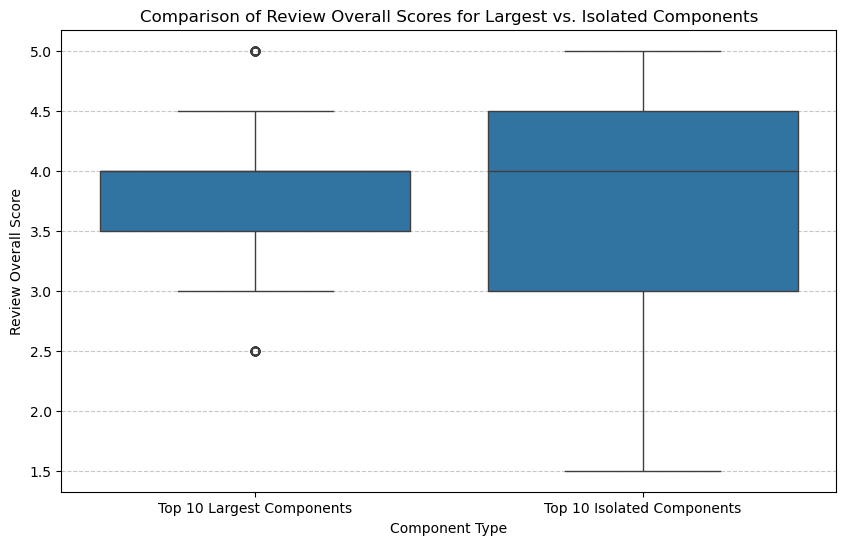

Generated a box plot comparing 'review_overall' scores for largest and isolated components.


In [160]:
df_largest = pd.DataFrame({
    'review_overall': largest_components_overall_reviews,
    'Component Type': 'Top 10 Largest Components'
})
df_isolated = pd.DataFrame({
    'review_overall': isolated_components_overall_reviews,
    'Component Type': 'Top 10 Isolated Components'
})

df_combined = pd.concat([df_largest, df_isolated])

plt.figure(figsize=(10, 6))
sns.boxplot(x='Component Type', y='review_overall', data=df_combined)
plt.title('Comparison of Review Overall Scores for Largest vs. Isolated Components')
plt.xlabel('Component Type')
plt.ylabel('Review Overall Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Generated a box plot comparing 'review_overall' scores for largest and isolated components.")

In [162]:
s2_overall_reviews = []
for node_id, attrs in S2.nodes(data=True):
    s2_overall_reviews.append(attrs.get('review_overall'))

if s2_overall_reviews:
    mean_s2_review = sum(s2_overall_reviews) / len(s2_overall_reviews)
    print(f"Mean overall review in S2: {mean_s2_review:.2f}")
else:
    print("No review_overall data found in S2 nodes.")

Mean overall review in S2: 3.70


In [164]:
print(f"Number of isolated components in S2: {len(isolated_components)}")

Number of isolated components in S2: 4751


In [178]:
reviewer_counts = Counter()

for node_id, attrs in S3.nodes(data=True):
    reviewer = attrs.get('profile_name')
    if reviewer:
        reviewer_counts[reviewer] += 1

if reviewer_counts:
    most_active_reviewer, num_reviews = reviewer_counts.most_common(1)[0]
    print(f"O revisor com mais avaliações no grafo S3 é: {most_active_reviewer} com {num_reviews} avaliações.")
else:
    print("Não foram encontrados dados de revisores no grafo S3.")

O revisor com mais avaliações no grafo S3 é: Duhast500 com 26 avaliações.


In [174]:
highest_centrality_node = max(eigenvector_centrality_s2, key=eigenvector_centrality_s2.get)
highest_centrality_score = eigenvector_centrality_s2[highest_centrality_node]

print(f"Node with highest eigenvector centrality: {highest_centrality_node.beer_name}")
print(f"Highest eigenvector centrality score: {highest_centrality_score:.4f}")

Node with highest eigenvector centrality: LongShot Traditional Bock
Highest eigenvector centrality score: 0.0854


In [176]:
connected_component_of_highest_centrality_node = nx.node_connected_component(S3, highest_centrality_node)

num_nodes_in_component = len(connected_component_of_highest_centrality_node)

print(f"The node with the highest eigenvector centrality is: {highest_centrality_node.beer_name}")
print(f"Number of nodes in the connected component containing this node: {num_nodes_in_component}")

The node with the highest eigenvector centrality is: LongShot Traditional Bock
Number of nodes in the connected component containing this node: 5


In [216]:
density_s2 = nx.density(S2)
density_s3 = nx.density(S3)

print(f"Density of graph S2: {density_s2:.6f}")
print(f"Density of graph S3: {density_s3:.6f}")

if density_s2 > density_s3:
    print("Graph S2 is denser than Graph S3.")
elif density_s3 > density_s2:
    print("Graph S3 is denser than Graph S2.")
else:
    print("Both graphs have the same density.")

Density of graph S2: 0.000592
Density of graph S3: 0.000336
Graph S2 is denser than Graph S3.
